In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from sklearn.preprocessing import FunctionTransformer
import numpy as np

In [2]:
def replace_saint_names(text):
    
    if type(text) != str:
        return text
    
    saint_names = ['sao ', 'sto ', 'santa ', 'santo ',  's. ']
    
    for saint in saint_names:
        text = text.replace(saint, 's.')
        if text.startswith(saint.strip()):
            text = text.replace(saint.strip(), 's.')

    return text

In [3]:
df_loc = pd.read_csv('./estado-sp-ibge.csv', decimal=',')
df_loc = df_loc[["Município [-]", "População residente - pessoas [2022]", "Densidade demográfica - hab/km² [2022]", "IDHM <span>Índice de desenvolvimento humano municipal</span> [2010]", "PIB per capita - R$ [2020]"]]
df_loc.columns = ["cidade", "populacao", "densidade", "idh", "pib"]
df_loc.loc[:, "cidade"] = df_loc["cidade"].str.normalize("NFKD").str.encode("ascii",  errors='ignore').str.decode("UTF-8").str.lower().map(replace_saint_names)

In [4]:
files = ["./furtos_consolidado.csv", "./roubos_consolidado.csv"]
df = pd.concat([pd.read_csv(f) for f in files])

/tmp/ipykernel_15775/2562627805.py:2: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f) for f in files])
/tmp/ipykernel_15775/2562627805.py:2: DtypeWarning: Columns (21,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f) for f in files])


In [5]:
df.columns = df.columns.str.lower()
df["datahora"] = pd.to_datetime(df["dataocorrencia"] + " " + df["horaocorrencia"], errors="coerce")
df = df[df["datahora"] > datetime(2020, 1, 1)]
df["hora"] = df["datahora"].dt.hour
df["ano"] = df["datahora"].dt.year
df["mes"] = df["datahora"].dt.month
df["dia"] = df["datahora"].dt.day
df["estacao"] = ((df["mes"] % 12) // 3) + 1
df["periodo"] = np.where(
    (df["hora"] >= 0) & (df["hora"] < 8), 0, 
    np.where((df["hora"] >= 8) & (df["hora"] < 16), 1, 2)
)
for c in ["cidade", "bairro", "logradouro"]:
  df.loc[:, c] = df[c].str.normalize("NFKD").str.encode("ascii",  errors='ignore').str.decode("UTF-8").str.lower().map(replace_saint_names)
df["bairro"] = df["cidade"] + "|" + df["bairro"]

df = df.merge(df_loc, on=["cidade"], how="left")

/tmp/ipykernel_15775/1916024345.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["datahora"] = pd.to_datetime(df["dataocorrencia"] + " " + df["horaocorrencia"], errors="coerce")


In [6]:
crimes = df[["cidade", "bairro", "logradouro", "estacao", "ano", "mes", "dia", "periodo", "densidade", "idh"]]

In [7]:
def sin_transform(x, period):
    return np.sin(x / period * 2 * np.pi)

def cos_transform(x, period):
    return np.cos(x / period * 2 * np.pi)

In [8]:
crimes.loc[:, "mes_sin"] = sin_transform(crimes["mes"], 12)
crimes.loc[:, "mes_cos"] = cos_transform(crimes["mes"], 12)
crimes.loc[:, "dia_sin"] = sin_transform(crimes["dia"], 30)
crimes.loc[:, "dia_cos"] = cos_transform(crimes["dia"], 30)

/tmp/ipykernel_15775/2427418647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimes.loc[:, "mes_sin"] = sin_transform(crimes["mes"], 12)
/tmp/ipykernel_15775/2427418647.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimes.loc[:, "mes_cos"] = cos_transform(crimes["mes"], 12)
/tmp/ipykernel_15775/2427418647.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [9]:
crimes.head()

,cidade,bairro,logradouro,estacao,ano,mes,dia,periodo,densidade,idh,mes_sin,mes_cos,dia_sin,dia_cos
0,limeira,limeira|vila claudia,avenida antonio ometo,1,2020,1,1,0,502.61,0.775,0.5,0.866025,0.207912,0.978148
1,birigui,birigui|chacaras caicara,rua benjamin strozi,1,2020,1,1,0,224.48,0.780,0.5,0.866025,0.207912,0.978148
2,birigui,birigui|jardim vitrine,rua silvio vieira coelho,1,2020,1,1,0,224.48,0.780,0.5,0.866025,0.207912,0.978148
3,praia grande,praia grande|solemar ii,avenida ministro marcos freire,1,2020,1,1,0,2338.32,0.754,0.5,0.866025,0.207912,0.978148
4,praia grande,praia grande|solemar ii,avenida ministro marcos freire,1,2020,1,1,0,2338.32,0.754,0.5,0.866025,0.207912,0.978148


In [10]:
to_score = ["cidade", "bairro", "estacao", "ano", "mes", "dia", "periodo"]
scored = []
neighborhood_crimes = crimes.copy()
for t in to_score:
  grouped = neighborhood_crimes.groupby(t).size().reset_index()
  name = f"{t}_PONTOS"
  scored.append(name)
  grouped.rename(columns={0: name}, inplace=True)
  neighborhood_crimes = neighborhood_crimes.join(grouped.set_index(t), on=t)

In [11]:
neighborhood_crimes["pontos"] = neighborhood_crimes[scored].sum(axis=1)
neighborhood_crimes = neighborhood_crimes.drop(columns=scored)

In [12]:
to_score = ["cidade", "bairro", "logradouro", "estacao", "ano", "mes", "dia", "periodo"]
scored = []
for t in to_score:
  grouped = crimes.groupby(t).size().reset_index()
  name = f"{t}_PONTOS"
  scored.append(name)
  grouped.rename(columns={0: name}, inplace=True)
  crimes = crimes.join(grouped.set_index(t), on=t)

In [13]:
crimes["pontos"] = crimes[scored].sum(axis=1)
crimes = crimes.drop(columns=scored)

<Axes: >

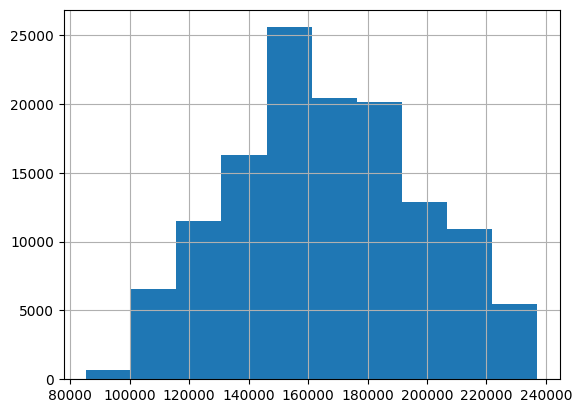

In [14]:
crimes["pontos"].hist()

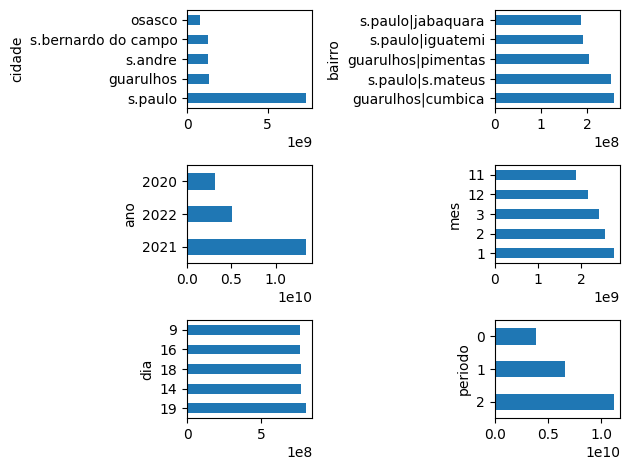

In [15]:
fig, axs = plt.subplots(3, 2)
to_plot = ["cidade", "bairro", "ano", "mes", "dia", "periodo"]
for t, ax in zip(to_plot, axs.ravel()):
    crimes.groupby(t)["pontos"].sum().sort_values(ascending=False).head().plot(kind="barh", ax=ax)
plt.tight_layout()

In [16]:
print(f"Total {crimes.shape[0]}\n")
print(crimes.isna().sum())
print()
print(crimes.isna().mean())

Total 130393

cidade          84
bairro        1036
logradouro    6774
estacao          0
ano              0
mes              0
dia              0
periodo          0
densidade      447
idh            447
mes_sin          0
mes_cos          0
dia_sin          0
dia_cos          0
pontos           0
dtype: int64

cidade        0.000644
bairro        0.007945
logradouro    0.051951
estacao       0.000000
ano           0.000000
mes           0.000000
dia           0.000000
periodo       0.000000
densidade     0.003428
idh           0.003428
mes_sin       0.000000
mes_cos       0.000000
dia_sin       0.000000
dia_cos       0.000000
pontos        0.000000
dtype: float64


In [17]:
crimes.dropna(inplace=True)
neighborhood_crimes.dropna(inplace=True)

In [18]:
crimes = crimes.assign(location=(crimes["cidade"] + "|" + crimes["bairro"] + "|" + crimes["logradouro"]).astype("category"))

In [19]:
crimes.to_csv("crimes_scored.csv", index=False)
neighborhood_crimes.to_csv("neighborhood_crimes_scored.csv", index=False)